<center>
<img align="center" src="http://sydney.edu.au/images/content/about/logo-mono.jpg">
</center>
<h1 align="center" style="margin-top:10px">Statistical Learning and Data Mining</h1>
<h2 align="center" style="margin-top:20px">Week 4 Tutorial: Linear Methods for Classification</h2>
<br>

In this tutorial we discuss how we you can use the logistic regression method in practical business decision-making application to credit risk. 

<a href="#1.-German-Credit-Data">German credit data</a> <br>
<a href="#2.-Training-and-validation-sets">Training and validation sets</a> <br>
<a href="#3.-Business-understanding">Business understanding</a> <br>
<a href="#4.-Some-EDA">Some EDA</a> <br>
<a href="#5.-Feature-engineering">Feature engineering</a> <br>
<a href="#6.-Logistic-regression">Logistic Regression</a> <br>
<a href="#7.-Gaussian-discriminant-analysis">Gaussian discriminant analysis</a> <br>
<a href="#8.-K-Nearest Neighbours">K-Nearest Neighbours</a> <br>
<a href="#9.-Validation-results">Validation results</a> <br>
<a href="#10.-AutoML-with-TPOT">AutoML with TPOT</a> <br>

This notebook relies on the following packages. Sometimes, you can get errors or even different results if you use different versions of the packages.

In [1]:
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

print(f'Package versions: \n')

print(f'numpy {np.__version__}')
print(f'scipy {scipy.__version__}')
print(f'pandas {pd.__version__}')
print(f'seaborn {sns.__version__}')
print(f'scikit-learn {sklearn.__version__}')

# Notebook tested on: 
# numpy 1.22.2
# scipy 1.7.1
# pandas 1.3.4
# seaborn 0.11.2
# scikit-learn 0.24.2

Package versions: 

numpy 1.20.3
scipy 1.3.1
pandas 1.2.5
seaborn 0.11.1
scikit-learn 1.0.1


The next cell is optional configuration.

In [2]:
# This is to clear the warnings from the notebook, usually we should leave this on
import warnings
warnings.filterwarnings('ignore')

# Plot settings
sns.set_context('notebook') # optimises figures for notebook display
sns.set_style('ticks') # set default plot style
colours = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', 
           '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(colours) # set custom color scheme
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

# 1. German credit data

This tutorial is based on the [German Credit Data](https://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29) available from the UCI Machine Learning repository. Each observation in the dataset represents a loan. The response variable is `default`, which takes a value of one if the client defaulted on the loan and zero if the client repaid the loan. 

In [3]:
# data = pd.read_csv('Data/german_credit.csv')
data = pd.read_csv('german_credit.csv')
data.head()

,status,duration,history,purpose,amount,savings,employment,installment_rate,personal,other_debtors,...,property,age,other_installment_plans,housing,existing_credits,job,people_under_maintenance,telephone,foreign_worker,default
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,1,1,0
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,0,1,1
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,0,1,0
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,0,1,0
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,0,1,1


There are 13 categorical predictors (two of them binary and already coded numerically) and 7 numerical predictors in the dataset. Refer to the [documentation](https://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29) for the explanation of the variables and the codes levels of the categorical variables. 

In [4]:
continuous = ['duration', 'amount', 'age']

discrete = ['installment_rate', 'residence', 'existing_credits', 'people_under_maintenance']

categorical = ['status', 'history', 'purpose', 'savings',  'employment', 'personal',  'other_debtors', 'property',
               'other_installment_plans', 'housing',  'job']

binary = ['telephone', 'foreign_worker']

response = ['default']

# 2. Training and validation sets

We will split the data into training and validation sets. For now, we only need to create an unprocessed version of the training data. 

In [5]:
from sklearn.model_selection import train_test_split

index_train, index_valid = train_test_split(np.array(data.index), stratify=data[response], 
                                            train_size=0.7, random_state=42)
train = data.loc[index_train,:].copy()

# 3. Business understanding

The data documentation specifies the following loss matrix: 

<table>
  <tr>
    <th>Actual/ Predicted</th>
    <th>Repayment</th>
     <th>Default</th>
  </tr>
  <tr>
    <th>Repayment</th>
    <td>0</td>
    <td>1</td>
  </tr>
  <tr>
    <th>Default</th>
    <td>5</td>
    <td>0</td>
  </tr>
</table>

That is, if we predict a default but the client repays the loan, the loss is 1.  If we predict that the client will repay the loan but there is a default, the loss is 5. The loss for a correct classification is 0. In general terminology, we say that the loss from a false positive is 1, the loss from a false negative is 5, and the loss from both true positives and true negatives is zero. 

Using the formula from the lecture, the decision threshold is: 

In [6]:
tau = 1 / (1 + 5)
print(f'Decision threshold: tau={round(tau,3)}')

Decision threshold: tau=0.167


If the probability of default is lower than 0.167, then we should classify the client as creditworthy. If the probability of default is higher than 0.167, then we should classify the loan as high risk. 

# 4. Some EDA


## 4.1 Descriptive statistics

The descriptive statistics allows us to verify that there are no missing values or apparent errors in the numerical variables.

In [7]:
train.describe().round(2)

,duration,amount,installment_rate,residence,age,existing_credits,people_under_maintenance,telephone,foreign_worker,default
count,700.00,700.00,700.00,700.00,700.00,700.00,700.00,700.00,700.00,700.00
mean,20.77,3200.87,2.94,2.82,35.47,1.40,1.16,0.40,0.96,0.30
std,11.96,2674.94,1.12,1.10,10.95,0.56,0.37,0.49,0.20,0.46
min,4.00,338.00,1.00,1.00,19.00,1.00,1.00,0.00,0.00,0.00
25%,12.00,1360.75,2.00,2.00,27.00,1.00,1.00,0.00,1.00,0.00
50%,18.00,2319.50,3.00,3.00,33.00,1.00,1.00,0.00,1.00,0.00
75%,24.00,3974.50,4.00,4.00,41.25,2.00,1.00,1.00,1.00,1.00
max,60.00,15945.00,4.00,4.00,75.00,4.00,2.00,1.00,1.00,1.00


## 4.2 Response variable

Defaults occur in 30% of the loans in the training data. 


In [8]:
train['default'].value_counts(normalize=True)

0    0.7
1    0.3
Name: default, dtype: float64

## 4.3 Continuous predictors 

As common in this type of data, some of the continuous variables are skewed. 

In [9]:
continuous

['duration', 'amount', 'age']

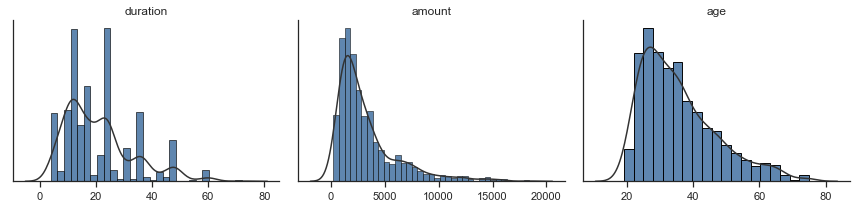

In [10]:
from tutorial4 import distplots

distplots(data[continuous])
plt.show()

## 4.4 Discrete and categorical predictors


The following  plots allow us to visualise the relationship between `default` and the remaining variables. The default rates seem to vary significantly according to the status of the existing checking account, savings, and credit history.

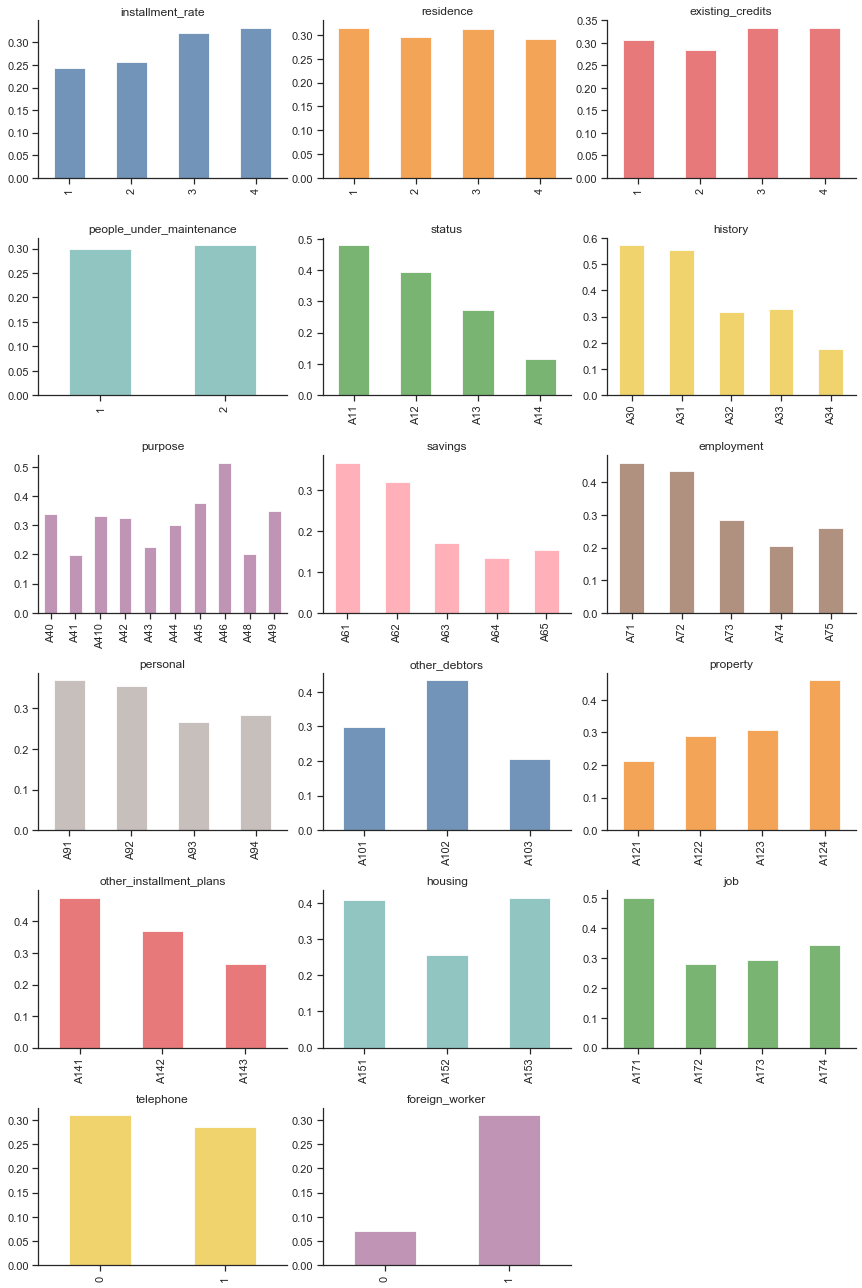

In [11]:
from tutorial4 import crosstabplots

crosstabplots(train[discrete + categorical + binary], train['default'])
plt.show()

## 4.5 Bivariate relationships

The duration and amount of the loan seem to have a relevant positive association with the default rates.

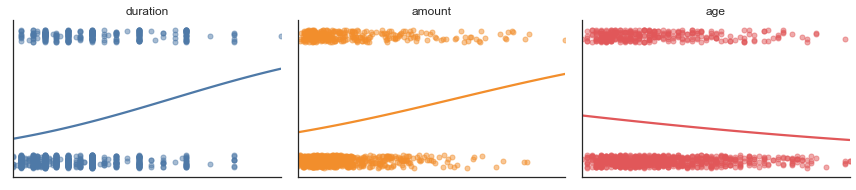

In [12]:
from tutorial4 import regplots

fig, ax = regplots(data[continuous], data['default'])
plt.show()

It's often useful to estimate the strength of association between the response and the predictors. Because the response is binary, we should use a measure that is suitable for estimating the strength of the relationship between a binary variable and numerical or categorical variables.  

The mutual information is a measure of dependence based on [information theory](https://en.wikipedia.org/wiki/Information_theory). Loosely speaking, it measures the distance between the joint distribution and the product of the marginal distributions. Recall that if two random variables are independent, then joint distribution is the product of the marginal distributions.

The mutual information takes a value of zero if there's no dependence. The higher the mutual information, the higher the dependence, but it does not have a fixed maximum value like a correlation. 

The scikit-learn package can estimate mutual information. However, we need to do this separately for continuous and discrete predictors.

In [13]:
from sklearn.feature_selection import mutual_info_classif

mi = mutual_info_classif(data[continuous], data['default'], random_state=1)
results1 = pd.DataFrame(mi, index=continuous, columns=['MI'])

The scikit-learn method only accepts numerical features. Therefore, we have to use the `OrdinalEncoder` to encode the categorical predictors with numerical labels. 

In [14]:
from sklearn.preprocessing import OrdinalEncoder
features = OrdinalEncoder().fit_transform(data[discrete + categorical + binary])

mi = mutual_info_classif(features, data['default'], n_neighbors=5, 
                         random_state=1, discrete_features=True)
results2 = pd.DataFrame(mi, index=discrete+categorical+ binary, columns=['MI'])

Finally, we concatenate the two sets of results into a single table. 

Status, duration and history are the three predictors with strongest relationships with default. 

In [15]:
results = pd.concat([results1, results2], axis=0).sort_values(by='MI', ascending=False).round(4)
results.round(4)

,MI
status,0.0657
duration,0.0334
history,0.0302
savings,0.0195
purpose,0.0173
amount,0.0145
property,0.0118
employment,0.0091
housing,0.0088
other_installment_plans,0.0062


The mutual information estimates can have high variance if there aren't many data points.

# 5. Feature engineering

We create a function that implements the feature engineering process below. Here are the key details: 

1. Yeo-Johnson transformation for the credit amount and age. The code allows you to verify that these transformations help. 

2. Dummy encoding for the categorical variables (all have low cardinality). 

3. Dummy encoding for the discrete variables (since all have low cardinality).

4. Standardisation for the numerical features (not strictly necessary this time, but it makes the optimisation algorithm more stable). 


In [16]:
# this code is just for ruuning, nothing new here compared to the feature engineering tutorial

from sklearn.preprocessing import PowerTransformer, StandardScaler

def feat_engineering(df, transformation=True):
    data = df.copy()
    
    # Dummy encoding or discrete and categorical variables
    dummies = binary[:] # copies list of binary predictors
    labels = discrete + categorical 
    for label in labels:
        features = pd.get_dummies(data[label], prefix=label, drop_first=True)
        data = data.join(features)
        dummies += list(features.columns)
    
    # Yeo-Johnson transformation
    transf = ['duration', 'amount', 'age']
    if transformation: 
        yj_transf = PowerTransformer(method='yeo-johnson').fit(data.loc[index_train, transf])
        data[transf] = yj_transf.transform(data[transf])
    
    # Standardisation
    labels = continuous
    scaler = StandardScaler().fit(data.loc[index_train, labels])
    data.loc[:, labels] = scaler.transform(data.loc[:, labels])
    
    predictors = continuous + dummies
    
    X_train = data.loc[index_train, predictors].to_numpy()
    X_valid = data.loc[index_valid, predictors].to_numpy()

    y_train = data.loc[index_train, response].to_numpy()
    y_valid = data.loc[index_valid, response].to_numpy()
    
    return X_train, np.ravel(y_train), X_valid, np.ravel(y_valid), predictors

X_train, y_train, X_valid, y_valid, predictors = feat_engineering(data)

# 6. Logistic Regression

Training the logistic regression model is simple.

In [17]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(penalty='none')
logit.fit(X_train, y_train)

LogisticRegression(penalty='none')

The next figure shows the largest estimated coefficients.  We will talk more about interpretability later in the course.

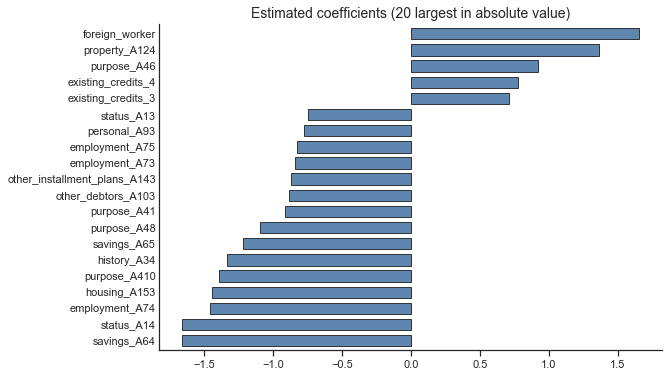

In [18]:
from tutorial4 import coefplot

coefplot(logit, predictors)
plt.show()

# 7. Gaussian discriminant analysis

Gaussian discriminant analysis (GDA) is covered in Chapter 4 of the ISL textbook. The following summarises all you need to know about this method for practical applications. Refer to the textbook for more details.

## 7.1 The method

GDA is a generative method for classification, which means that it specifies a model for the joint distribution of the response and the predictors.  GDA assumes that the predictors follow the multivariate normal distribution conditional on each class. We can then use Bayes' theorem to compute the class probabilities conditional on the predictor values.

In contrast, most probabilistic methods for supervised learning specify a model directly for the conditional distribution of the response given the predictors. In this case, we do make any distributional assumptions regarding the predictors. 

There are four variations:

* Gaussian naive Bayes assumes that all predictors are independent conditional on the class. Because the predictors are Gaussian, this is the same as assuming that all predictors are uncorrelated given the class. Or equivalently, that the class-conditional covariance matrices are diagonal. 
* Linear discriminant analysis (LDA), we assume all classes have the same covariance matrix. This assumption implies a linear decision boundary, just like in the logistic regression model.
* Quadratic discriminant analysis (QDA) is the most general case that assumes the covariance matrices are class specific This implies quadratic decision boundaries.   
* Regularised QDA is a compromise between QDA and Gaussian naive Bayes. 

Always remember that useful assumptions can help the learning algorithm to generalise, even if they are not strictly correct. If the predictors are in fact approximately Gaussian conditional on the class, Gaussian discriminant analysis will tend to perform better than the logistic regression model.

Surprisingly, there are many applications where discriminant analysis works well even if the assumption of normality is clearly false.


## 7.2 Training

Gaussian discriminant analysis does not seem relevant here since most features are dummy variables. Nevertheless, let's fit LDA and regularised QDA models to learn the code and experiment.

In [19]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

qda = QuadraticDiscriminantAnalysis(reg_param = 0.5)
qda.fit(X_train, y_train)

QuadraticDiscriminantAnalysis(reg_param=0.5)

# 8. K-Nearest Neighbours

Let's also use a kNN classifier for comparison. 

In [20]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=30)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=30)

There are a few factors that work against kNN here: 

* It tends not to perform well when there are more than a few predictors.
* It does not handle mixed variable types well.
* It's not well-suited for predicting probabilities. 

# 9. Validation results

The next cell computes several relevant metrics for the validation set. The most important metric is the average loss, which estimates the population risk. It directly measures the business value of different models. 

Here's the interpretation of the other metrics (taking the logistic regression model as an example): 

**Sensitivity:** the model correctly predicted 85.6% of the defaults in the validation set.

**Specificity:** the model correctly predicted 55.7% of repayments in the validation set.

**Precision:** out of the loans that we were classified as high risk, 45.3% were actual defaults. 

**AUC:** the AUC is a measure of how well the model trades off sensitivity and specificity. The better the model predicts the condititional probability of default, the higher the AUC is. The AUC takes values between 0 and 1, where 0.5 corresponds an uninformative classifier. 

**Cross-entropy**: the logistic regression method optimises this metric within the training set. The better a model predicts the condititional probability of default, the lower the cross-entropy.

In [21]:
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.metrics import precision_score, log_loss

columns = ['Loss', 'SE', 'Sensitivity', 'Specificity', 'Precision', 'AUC', 'Cross-entropy']
rows = ['Logistic regression', 'LDA', 'QDA', 'KNN']
results = pd.DataFrame(0.0, columns=columns, index=rows) 

methods=[logit, lda, qda, knn]

y_valid = np.ravel(y_valid)
y_prob = np.zeros((len(y_valid), len(rows)))

for i, method in enumerate(methods):    
    
    y_prob[:,i] = method.predict_proba(X_valid)[:,1]
    y_pred = (y_prob[:,i] > tau).astype(int)

    loss =  5*((y_pred!=y_valid) & (y_pred==0)) + 1*((y_pred!=y_valid) & (y_pred==1))

    tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel() 

    results.iloc[i,0] =  np.mean(loss) # or (fp*1+fn*5)/len(y_test)
    results.iloc[i,1] =  np.std(loss)/np.sqrt(len(y_valid))
    results.iloc[i,2] =  tp/(tp+fn)
    results.iloc[i,3] =  tn/(tn+fp)
    results.iloc[i,4] =  precision_score(y_valid, y_pred)
    results.iloc[i,5] =  roc_auc_score(y_valid, y_prob[:,i])
    results.iloc[i,6] =  log_loss(y_valid, y_prob[:,i])

results.round(3)

,Loss,SE,Sensitivity,Specificity,Precision,AUC,Cross-entropy
Logistic regression,0.527,0.061,0.856,0.557,0.453,0.787,0.503
LDA,0.520,0.059,0.867,0.543,0.448,0.790,0.497
QDA,0.587,0.049,0.922,0.329,0.371,0.764,0.509
KNN,0.580,0.046,0.933,0.314,0.368,0.744,0.531


The following figure shows the ROC curves.

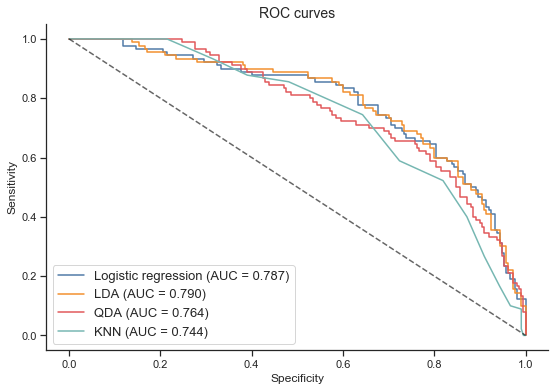

In [23]:
from tutorial4 import rocplot

fig, ax = rocplot(y_valid, y_prob, labels=pd.Series(rows))
plt.show()

# 10. AutoML with TPOT

This is optional material beyond the tutorial. 

Automated Machine Learning (AutoML) is an area of machine learning that seeks to automate one or multiple steps in the development of machine learning pipelines, for example data preparation and model selection. The promise of AutoML is to allow even non-experts to build useful machine learning models with minimal effort. 


AutoML is a very active area of research in machine learning and there has been a lot of progress in recent years. Because the demand for machine learning experts outstrips supply, there are strong incentives for the development of AutoML frameworks. Well-known commercial products included DataRobot AutoML, Google Cloud AutoML and H2O Driverless AI.
Fortunately, there are also excellent open-source AutoML tools that can help you wherever you are in your machine learning journey.

[TPOT](http://epistasislab.github.io/tpot/) uses an optimisation technique called genetic programming to search over a broad range scikit-learn pipelines (supervised learning algorithms together with preprocessing steps) to find a well-performing model for regression and classification.

All that you need to know about TPOT is that the higher the `generations` and `population_size` parameters in the code below,  the better the chances that it will find a good model for classification. The catch with AutoML is that you are supposed to run the algorithm for a long time, hours to days!

Try the code below and see if it the model found by TPOT improves the validation metrics. It's configured to run only for a few minutes, but you can increase `generations` and `population_size` to get better results. 

In [24]:
raise ValueError

ValueError: 

In [ ]:
%%time 

from tpot import TPOTClassifier

tpot = TPOTClassifier(generations=10, population_size=50, verbosity=2, 
                      scoring='neg_log_loss', random_state=42, n_jobs=-1)
tpot.fit(X_train, y_train)